# Fraud Detection - Classification (binary)
### Lifecycle
![Business Model Canvas](../images/lifecycle.png)


## Plan

### Business Model Canvas

![Business Model Canvas](../images/business-model-canvas.png)
### Use case
We want to create a machine learning model to identify fraud detections and prevent them before the transaction is processed,
and so that we have a tool to prevent fraud. Detecting fraud is one of our key activities (business model canvas) and therefore of great importance for our company.

### Problem
Fraud is an expensive problem, this is why we need to minimize it in order to run our business profitable.

Our customers want to feel safe while using our service and we need satisfied customers to run our business.

By reducing fraud we improve user experience, user satisfaction and strenghten our position in the market to be the market dominant company.

[Source](https://www.paypal.com/us/brc/article/enterprise-solutions-tranform-digital-commerce-with-adaptive-risk-mgmt)

### Relevant metrics
We want to find patterns from data which allows us to detect fradulent transactions.

For this binary calssification problem, where we want to detect fraud transactions, we are interested in "X versus not-X" instead of "X versus Y".

For "X versus not-X" we want to spot the fradulent transactions rather than a true distinction between Transactions *(ROC Curve would be a more suitable measure if it comes to distinguish between two classes)*

This is why **precision/recall** metric would be appropriate for this use case.

For precision we ask:

Of **all fradulent transactions we found** with our model, **how many were actually fraud?**

For recall we ask:

Of **all existing** fraud transactions, **how many of them did we find** with our model?

We can think of the


**recall** as the "whole truth" 

**precision** as "nothing but the truth"




## Data
We will analyze the data using plots and statistics, then we will clean and engineer the features 

### Data ingestion

read in test and training data using pandas read csv function.

combine both datasets in one dataframe for exploration and feature engineering, we will split the dataset later in test and train


In [136]:
## imports ##
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
# set plot style
sns.set_style("whitegrid")


In [137]:
# read
df_test = pd.read_csv("fraudTest.csv")
df_train = pd.read_csv("fraudTrain.csv")
# concat and drop "Unnamed 0" axis
df_full = pd.concat([df_test,df_train])
df_full.drop("Unnamed: 0", axis=1, inplace=True)
# quick look at the data
#df_full.describe(include="all")

### Analysing the data
We will get an insight in our data by plotting the features

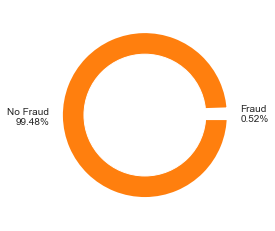

In [116]:
frauds = round((df_full[df_full['is_fraud']==1].shape[0] / df_full.shape[0]) * 100,2)
non_frauds = round((df_full[df_full['is_fraud']==0].shape[0] / df_full.shape[0]) * 100,2)
names = [f'Fraud\n{frauds}%', f'No Fraud\n{non_frauds}%']
size = [frauds,non_frauds]
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 10, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Unfortunately our dataset is highly imbalanced.

KNN Classifier assumes no probability distribution of the data like other classifiers, but is nevertheless not incapable of unbalanced data sets.

We will test different parameters for the distance measure during grid search to possibly tackle this problem with weighted nearest neighbors.

Another way to deal with unbalanced data is over- or undersampling. In this case, data sets are removed or added to the data set in order to achieve a more balanced distribution of the data.

Unfortunately, our dataset is **extremely** unbalanced, so we would have to multiply all fraud feature vectors, which would have a negative effect on our dataset.

On the other hand, undersampling would not be the best solution either, since we would have to remove an extremely large number of datasets from the dataset.

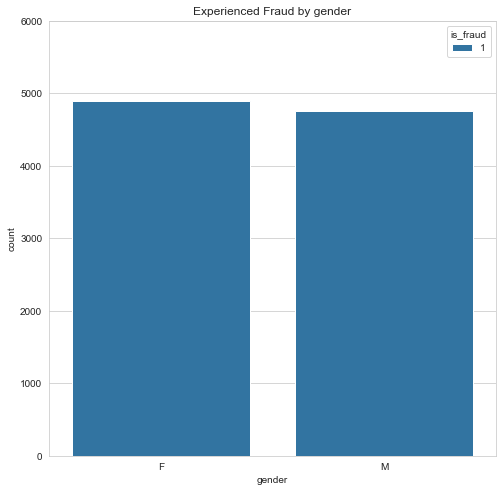

In [71]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x="gender", hue="is_fraud", data=df_full[df_full['is_fraud']==1], ax=ax)
ax.set(ylim=(0, 6000))
ax.set_title('Experienced Fraud by gender')
plt.show()


Women and men are affected by fraud in fairly equal numbers

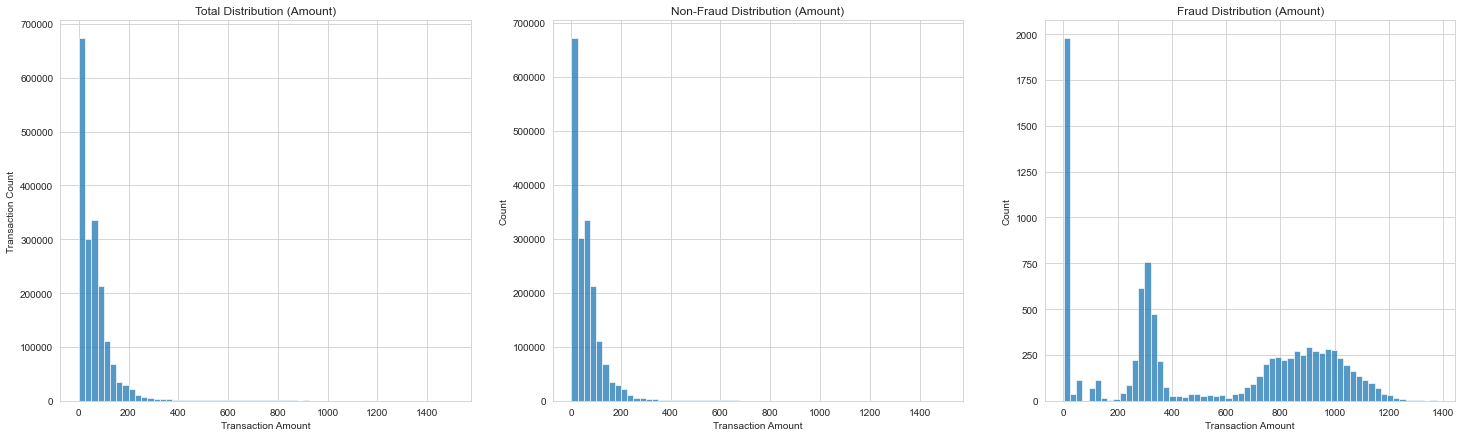

In [138]:
# get metrics for plotting distributions
total_dist= df_full[df_full['amt']<=1500]['amt']
non_f_dist = df_full[(df_full['is_fraud']==0) & (df_full['amt']<=1500)]['amt']
f_dist = df_full[(df_full['is_fraud']==1) & (df_full['amt']<=1500)]['amt']

fig, ax = plt.subplots(1,3,figsize=(25,7))

sns.histplot(total_dist, ax=ax[0], bins=60)
ax[0].set_title('Total Distribution (Amount)')
ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('Transaction Count')

sns.histplot(non_f_dist, ax=ax[1], bins=60)
ax[1].set_title('Non-Fraud Distribution (Amount)')
ax[1].set_xlabel('Transaction Amount')

sns.histplot(f_dist, ax=ax[2], bins=60)
ax[2].set_title('Fraud Distribution (Amount)')
ax[2].set_xlabel('Transaction Amount')
plt.show()


Lets zoom in

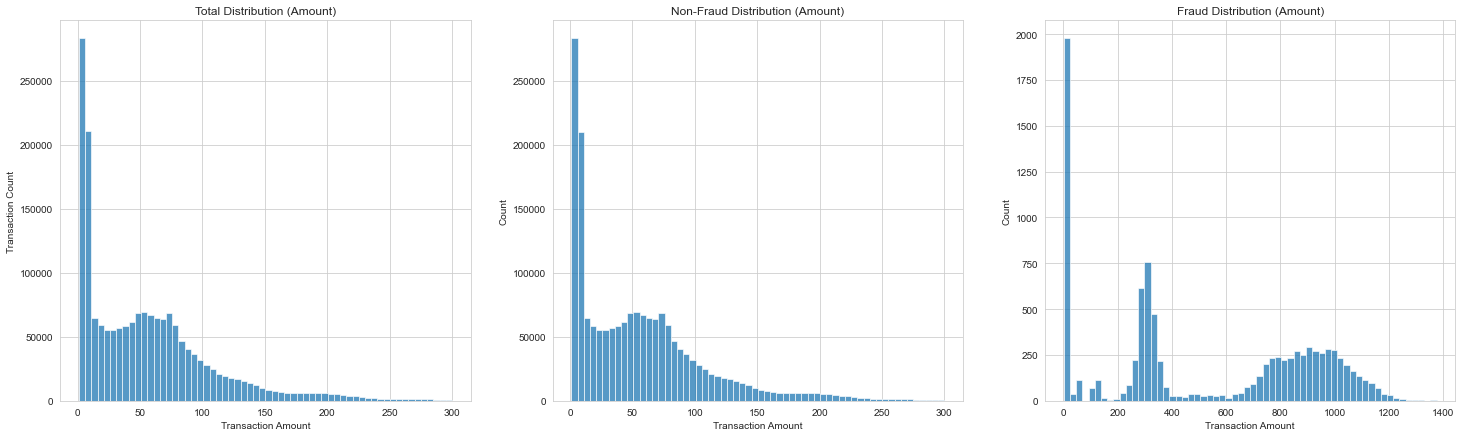

In [259]:
# get metrics for plotting distributions
total_dist= df_full[df_full['amt']<=300]['amt']
non_f_dist = df_full[(df_full['is_fraud']==0) & (df_full['amt']<=300)]['amt']
f_dist = df_full[(df_full['is_fraud']==1) & (df_full['amt']<=1500)]['amt']

fig, ax = plt.subplots(1,3,figsize=(25,7))

sns.histplot(total_dist, ax=ax[0], bins=60)
ax[0].set_title('Total Distribution (Amount)')
ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('Transaction Count')

sns.histplot(non_f_dist, ax=ax[1], bins=60)
ax[1].set_title('Non-Fraud Distribution (Amount)')
ax[1].set_xlabel('Transaction Amount')

sns.histplot(f_dist, ax=ax[2], bins=60)
ax[2].set_title('Fraud Distribution (Amount)')
ax[2].set_xlabel('Transaction Amount')
plt.show()

Here we see the distribution of the transaction volume.
In the first chart we see the distribution of all transactions, fraudulent and non-fraudulent.

In the second chart we see only the non-fraudulent transactions. 

In the third chart we see only the fraudulent ones.

There is a left-skewed distribution for all transactions in total and for non-fraudulent ones.

For fraudulent transactions, the distribution is bi or trimodal.

It is noticeable that most of the transactions have a volume under 100.

In the case of fraudulent transactions, the distribution belly is very small, under 10 dollars, around 300 dollars and long belly over 800 to 1100 dollars.

Text(0.5, 1.0, 'Number of frauds by category')

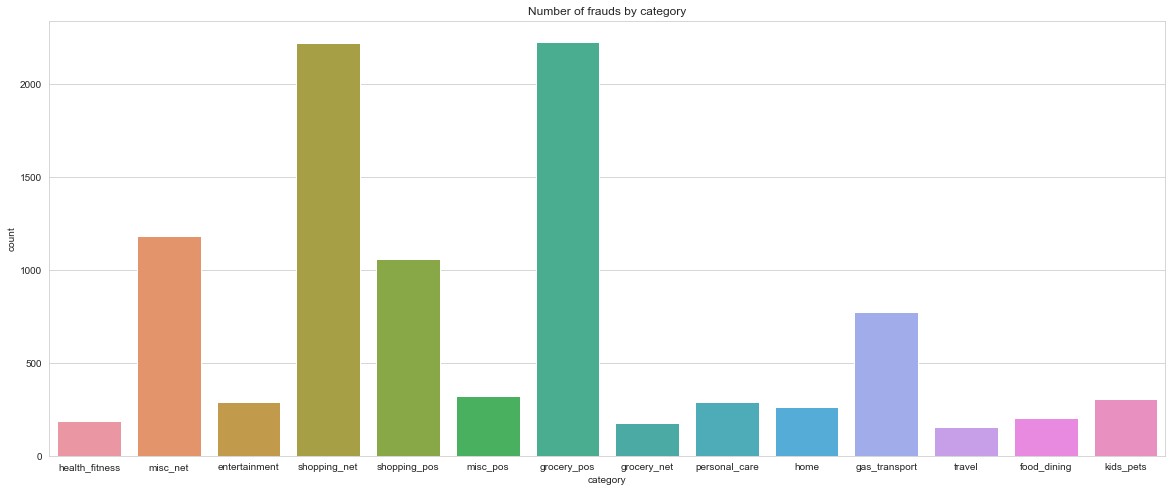

In [75]:
# Category
fig, ax = plt.subplots(figsize=(20,8))
sns.countplot(x="category", data=df_full[df_full['is_fraud']==1])
plt.title('Number of frauds by category')
plt.show()


From this chart, we can see that internet shopping and grocery shopping are the most affected by fraud.

Grocery shopping could explain the peak in the distribution of fraudulent transactions in the low double digits.

### Feature engineering
The feature date ob birth "dob" is not correctly formatted as datetime, we change the datatype to datetime

From the date of birth we can derive the new feature age

To use the feature gender we use the label encoder from skicit learn and one hot encode the feature

#### Categorical vs numerical data
**Categorical data** refers to a data type that can be stored and identified based on the names or labels given to them.

**Numerical data** refers to the data that is in the form of numbers, and not in any language or descriptive form.

a **categorical** feature is a set of discrete values for example {fork, spoon, knife}

a **binary categorical** feature consists of two discrete values for example gender {woman, man}

an **ordinal** feature is a set of **ordered** values for example {Bachelor<Master<PhD}

a **numerical** feature is a set of numerical values (quantitative or continuous) for example age 

if the numerical feature has values where one value can be meaningful expressed as a multiple of another value, the feature is **ratio scaled**

In [139]:
df_full['dob'] = pd.to_datetime(df_full['dob'])
df_full['trans_date_trans_time'] = pd.to_datetime(df_full['trans_date_trans_time'])
df_full['age'] = np.round((df_full['trans_date_trans_time'] - df_full['dob'])/np.timedelta64(1,'Y'))

We create the feature date of birth and create the feature age from it.

In [140]:
# one hot encode as binary feature
label_encoder = LabelEncoder()
df_full['gender_bin']  = label_encoder.fit_transform(df_full.gender)

We one hot encode the feature gender to use it with the knn model

#### KNN needs data to be numerical for creating the feature space and measuring distances
to use categorical data like gender, we can one hot encode this feature.

A very important step for KNN is to normalize the data, we use the range from [0 - 1].

In [141]:
df_num = df_full.select_dtypes(exclude="object")

We create a dataframe that contains only features with numeric datatypes.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


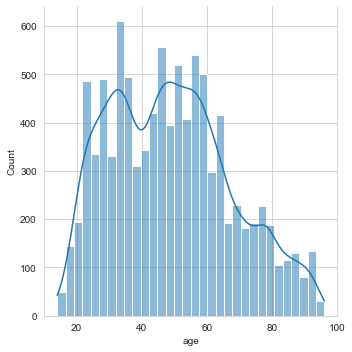

In [143]:
dist = df_num[df_num['is_fraud']==1]
dist.reset_index(inplace=True)
sns.displot(data=dist, x="age", ax=ax, kde="True")
#ax.set_title("Fraud distribution by age")

The new age feature allows us to view the distribution of fraudulent transactions by age.

It occurs in all age groups and corresponds probably to the normal distribution of age in population.

### Correlations between numerical features

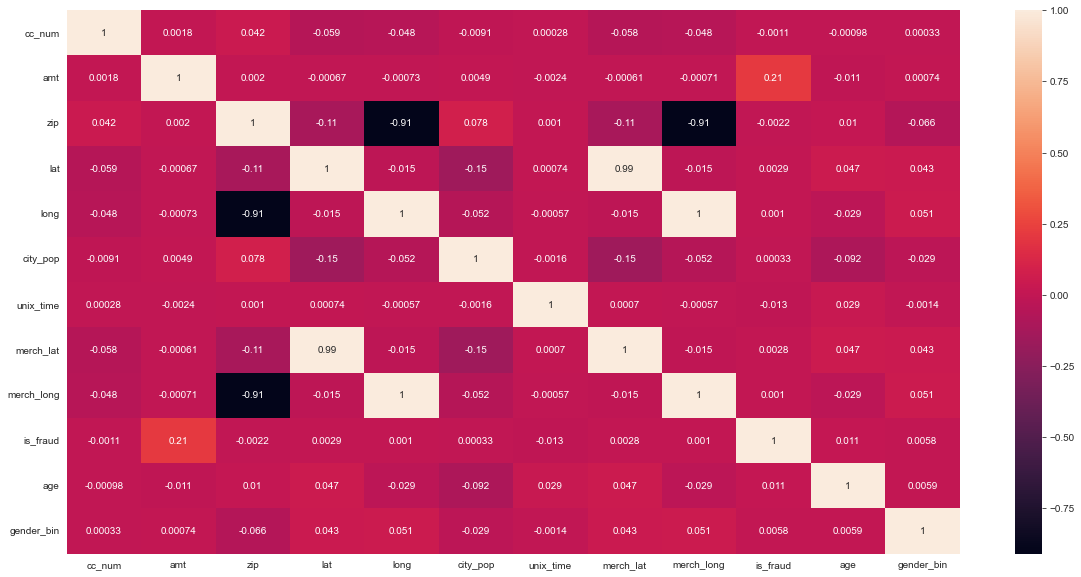

In [144]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_full.corr(), annot=True)
plt.show()

Actually, correlations don't matter too much because our classifier is based on distance measures and a KNN classifier can't distinguish which feature has high significance on our target variable and which doesn't.

Each feature counts equally in our KNN model. We still look at how our features correlate. 

As expected, the location-based features such as latitude, longitude, and zip code correlate with each other. 

The highest impact on our feature is the transaction volume (amount), for which we have already looked at the differences in the distribution.


## Model

### Separate Dataset into Features (X) and Labels (y)

In [ ]:
y = df_num["is_fraud"]
X = df_num.drop(["is_fraud" ,"trans_date_trans_time","dob"], axis=1)

### Define helper functions
We define some functions for the Grid Search process.

The Function apply_pca returns a test and train data with principal component analysis applied.

In the parameter we can specify how many Features the datasets should contain.

The funtion plot_cv_results plots the results from the Grid Search for every iteration, and is called after the grid search.

In [181]:
def apply_pca(n, x_train, x_test):
    pca = PCA(n_components=n)
    train = pca.fit_transform(x_train)
    test = pca.transform(x_test)
    return train, test

### Define custom scorer for precision recall scoring measure in Grid Search

<function matplotlib.pyplot.show(close=None, block=None)>

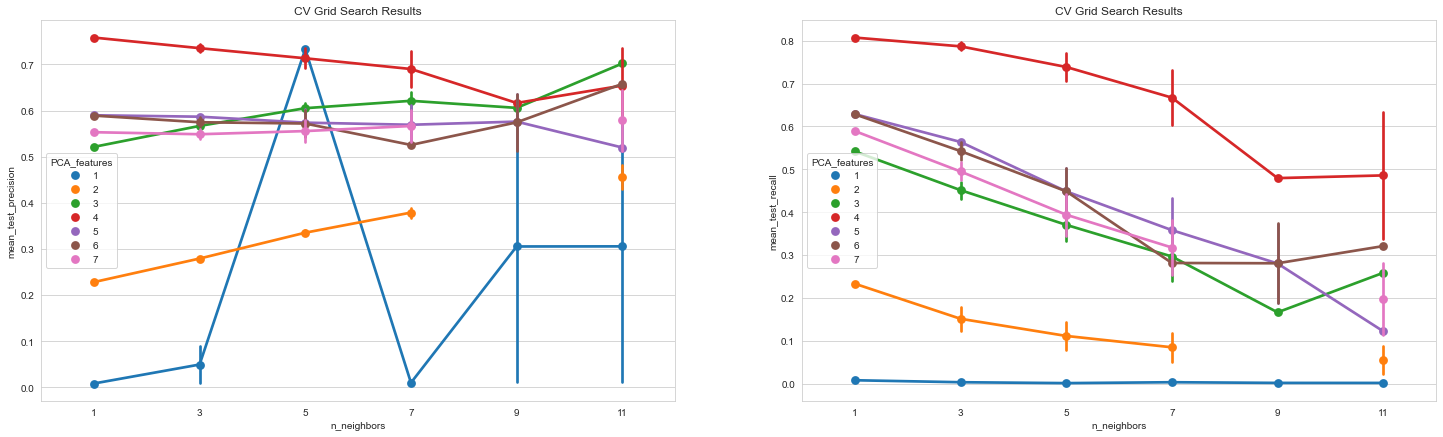

In [233]:
def plot_cv_results(cv_results, param_x, param_z, axis, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    #figure, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=axis)
    axis.set_title("CV Grid Search Results")
    axis.set_xlabel(param_x)
    axis.set_ylabel(metric)
    axis.legend(title=param_z)
    return ax


fig, ax = plt.subplots(1,2,figsize=(25,7))
plot_cv_results(result_df, 'n_neighbors', 'PCA_features', ax[0], metric='mean_test_precision')
plot_cv_results(result_df, 'n_neighbors', 'PCA_features', ax[1], metric='mean_test_recall')
plt.show

To find the best parameters for our model we use a randomized grid search.

The parameters to be tested are the number of nearest neighbors used for the classification of a test input and the distance measure.

Since we have an unbalanced dataset, we test if we can improve the results of the model by weighting neighbors that are further away differently than neighbors that are closer to the test point (distance measure weighted) instead of weighting each neighbor point equally regardless of its distance (distance measure uniform).

In addition, dimensions play an important role in the KNN classifier.

The so-called **"curse of dimensions"** means that with increasing dimensionality of the model, the data set must be exponentially enlarged to enable a sufficiently good density for classification.

If in a two-dimensional space (two features) a density of 100 points is sufficient for a good classification, then in a three-dimensional space (after adding a feature) it must be 100 * 100 = 10,000 points to obtain the same density, and so on.
In a high-dimensional space with several thousand dimensions, all points of the data set are closer to one edge of the space than to another point.

this leads to the fact that each newly calssified test input is several standard deviations away from another point and thus each point can be considered an outlier.

In addition, the difference between the farthest and the nearest point shrinks so much that distance measures can lose their meaningfulness.

We therefore apply pricipal component analysis (PCA) to reduce the dimensions and perform the randomized grid search for 7 different dimensions obtained by PCA.

In this way, we can find out the optimal parameters for the optimal number of dimensions.

### Model training and tuning
Using Grid Search


We create a custom scorer for evaluate model based on precision and recall score.

In [214]:
from sklearn.metrics import make_scorer, precision_score, recall_score

def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan
    try:
        score = actual_scorer(y_true, y_pred)
    except ValueError: 
        pass

    return score

prec = make_scorer(custom_scorer, actual_scorer = precision)
recall = make_scorer(custom_scorer, actual_scorer = recall_score)
scoring_dict = {"recall": recall, "precision": prec}

Start the randomized search

*(Note: this took about an hour, the results are obtained in cv_result_precision_recall.xlsx or cv_result_precision_recall.csv)*

In [ ]:
MAX_NUM_PCA_FEAT = 7
result_df = pd.DataFrame()
from sklearn.metrics import make_scorer, precision_score, recall_score

def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan
    try:
        score = actual_scorer(y_true, y_pred)
    except ValueError: 
        pass
    return score



for i in range(1,MAX_NUM_PCA_FEAT+1):
    print(f"***PCA {i}/{MAX_NUM_PCA_FEAT+1}***")
    # split dataset
    xtrain, xtest, y_train, y_test = train_test_split(X,y,train_size = 0.7 , random_state = 10)
    print(f"Test Dist:\nNo Fraud:{y_test.value_counts()}\nFraud:{y_test.value_counts()}")

    # normalize data
    min_max_scaler = MinMaxScaler()
    xtrain[X.columns] = min_max_scaler.fit_transform(xtrain[X.columns])
    xtest[X.columns] = min_max_scaler.fit_transform(xtest[X.columns])

    # pca
    X_train, X_test = apply_pca(i, xtrain, xtest)
    
    ### Determining the number of neighbors using RandomizedSearchCV
    param_grid = {
        'n_neighbors': [1,3,5,7,9,11],
        'weights': ['uniform','distance']

        }
    
    prec = make_scorer(custom_scorer, actual_scorer = precision_score)
    recall = make_scorer(custom_scorer, actual_scorer = recall_score)
    ###
    knn = RandomizedSearchCV(KNeighborsClassifier(), param_grid, verbose=3, scoring={"recall": recall, "precision": prec}, refit='precision', return_train_score=True)
    knn.fit(X_train,y_train)
    ###

    plot_df = pd.DataFrame(knn.cv_results_)
    plot_df["param_PCA_features"] = i    
    result_df = result_df.append(plot_df)

# reset index because while appending the dataframes in grid search we ignored the index so no index is created yet
result_df = result_df.reset_index()
# drop column created by resetting index
result_df.drop("index", axis=1, inplace=True)


Safe results from Grid Search in Excel and CSV

In [221]:
#result_df.to_excel('cv_result_precision_recall.xlsx')
#result_df.to_csv('cv_result_precision_recall.csv')


In [ ]:
## optional: read grid search result df from csv ##
#result_df = pd.read_csv("cv_result_precision_recall.csv")

Plot the results from Grid Search

<function matplotlib.pyplot.show(close=None, block=None)>

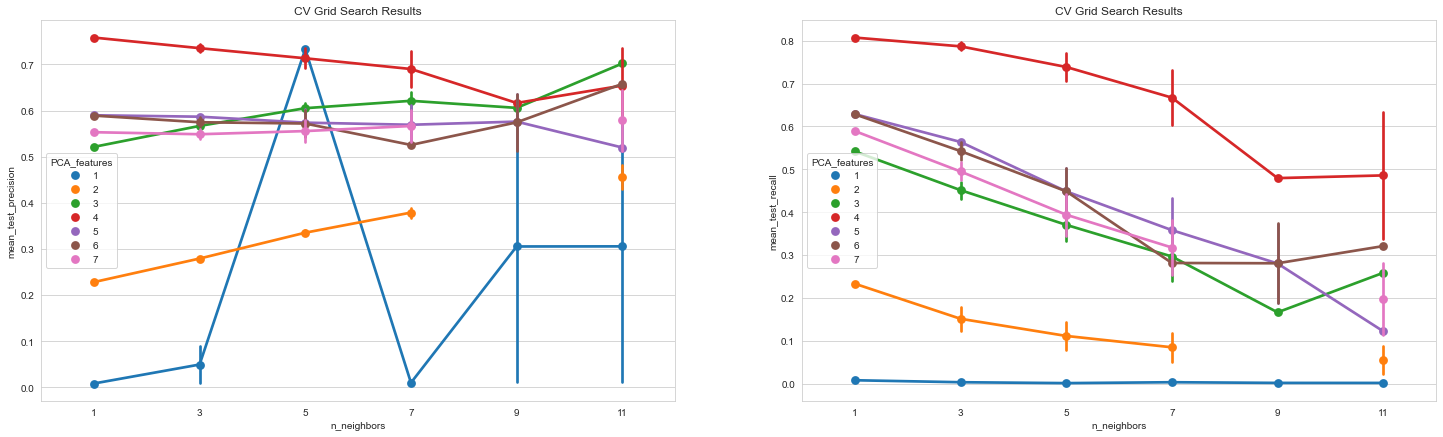

In [256]:
def plot_cv_results(cv_results, param_x, param_z, axis, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    #figure, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=axis)
    axis.set_title("CV Grid Search Results")
    axis.set_xlabel(param_x)
    axis.set_ylabel(metric)
    axis.legend(title=param_z)
    return ax


fig, ax = plt.subplots(1,2,figsize=(25,7))
plot_cv_results(result_df, 'n_neighbors', 'PCA_features', ax[0], metric='mean_test_precision')
plot_cv_results(result_df, 'n_neighbors', 'PCA_features', ax[1], metric='mean_test_recall')
plt.show

We plot the results of the grid search, on the X axis is the parameter "number of neighbors" and the different colors represent the different dimensions.

The confidence interval represents the different distance metrics (uniform or weighted).

On the left graph is the precision metric on the Y axis and on the right graph is the recall metric on the Y axis. Higher values are better, 1 is the best 0 is the worst.
Some results could not be determined, which is why points are missing.

We see that the difference between the distance metrics has an effect especially with a high number of neighbors, which is logical since with only one point less effects are made if this is weighted differently.

the more points are taken into account, the greater the distance between these points and the better the weighted distance measure can then play out its advantages, especially when we see that with less neighbors the results are overall better.

Surprisingly, the highest accuracy has been achieved with k=1, and this in 4 dimensions, both for precision and recall with the normal uniform distance measure (for a point, it does not really matter whether the points are weighted or not).

Surprisingly, because with k the decision boundary of the model is defined.
The higher k is chosen, the softer the decision boundary becomes and the model becomes more robust against noise and outliers.
Therefore, overfitting can occur for smaller values of k (and underfitting for very large values of k).

So maybe our unbalanced dataset could be a reason why k=1 gives the best performance.

Order the results from grid search in dataframe by best precision/recall on test set

In [253]:
result_df.sort_values(by='mean_test_precision', inplace=True, ascending=False)
result_df[['mean_test_precision', 'mean_test_recall', 'param_n_neighbors','param_weights', 'param_PCA_features']].head()

,mean_test_precision,mean_test_recall,param_n_neighbors,param_weights,param_PCA_features
30,0.758346,0.807138,1,uniform,4
31,0.743779,0.796134,3,distance,4
33,0.736342,0.633309,11,distance,4
32,0.734728,0.770409,5,distance,4
7,0.733333,0.001338,5,uniform,1


We see the final hyperparameters of the grid search.

With n = 1 nearest neighbors, uniform distance measure and 4 features of the pricipal component analysis, the highest recall and the highest precision value is achieved.

### Create the best model based on parameters from Grid Search

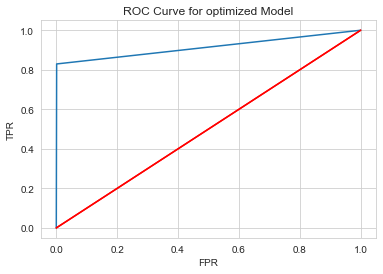

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552792
           1       0.79      0.83      0.81      2927

    accuracy                           1.00    555719
   macro avg       0.89      0.91      0.90    555719
weighted avg       1.00      1.00      1.00    555719



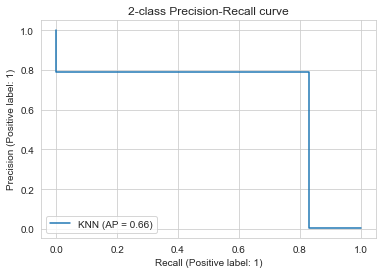

In [254]:
xtrain, xtest, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 12)
# normalize data
min_max_scaler = MinMaxScaler()
xtrain[X.columns] = min_max_scaler.fit_transform(xtrain[X.columns])
xtest[X.columns] = min_max_scaler.fit_transform(xtest[X.columns])

# pca
X_train, X_test = apply_pca(4, xtrain, xtest)

#KNN model
knn = KNeighborsClassifier(weights='distance',n_neighbors=1)
model = knn.fit(X_train,y_train)
ypred = model.predict(X_test)

prob = model.predict_proba(X_test)[:,1]
fpr,tpr,threshold = roc_curve(y_test,prob)
#Plotting Roc Curve
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red',linestyle = '-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for optimized Model')
plt.show()
#########
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(y_test, prob, name="KNN")
_ = display.ax_.set_title("2-class Precision-Recall curve")


print(classification_report(y_test,ypred))

We plot the ROC (receiver operating characteristic) curve. This curve measures how well a binary classifier is able to separate two different distributions. The area under the curve (are under curve AUC) indicates the percent quality, 1 stands for 100 percent accurate discrimination between data A and data B.

Since we are less interested in separating two but more interested in recognizing something, this is not our main metric, we look at the curve anyway.

The precision and recall curve is our main metric. We have a recall value of 83% and a precision of 79% for fraudulent transactions.

This means we detected 83% of all fraudulent transactions that were in our dataset.

Of the transactions that we classified as fraudulent, 79% were also truly fraudulent transactions. 

We can be satisfied with this result (anything better than 50% is better than guessing ;) ).

## Deployment - deploy the model

The Model is now ready for deployment